# 用户和作者聚类分析

对于抖音平台本身而言，如何对用户进行分类，或者分级，然后差异化的提供服务，是一个非常重要的方向

对于商务合作和广告投放者而言，如何对作者进行分类，如何选择合作的作者，也是有一定价值的问题

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [9]:
user_df = pd.read_csv('用户特征.csv')
user_df.head()

,uid,浏览量,点赞量,观看作者数,观看作品数,观看作品平均时长,观看配乐数,完整观看数,去过的城市数,观看作品所在的城市数
0,0,34,0,31,34,12.058824,31,18,1,28
1,1,28,1,28,28,12.357143,26,14,1,25
2,2,56,0,56,56,10.357143,47,19,3,45
3,3,117,1,116,117,9.982906,89,60,1,76
4,4,123,0,117,123,10.853659,94,77,1,84


In [10]:
author_df=pd.read_csv("作者特征.csv")
author_df.head()

,author_id,总作品数,总浏览量,总点赞量,总观完量,使用的配乐数量,去过的城市数,发布作品的日期数,作品的平均时长,创造活跃度(日)
0,0,1,1,0,0,1,1,1,10.000000,1
1,1,3,16,0,8,3,1,3,8.875000,9
2,3,1,311,3,203,1,1,1,9.000000,1
3,5,5,1054,33,485,4,1,5,7.040797,28
4,8,1,4,0,3,1,1,1,19.000000,1


In [11]:
#筛选出筛选认为至少观看过一个完整短视频且有一定浏览量的用户再进行分析
#让分析更有意义
user_data=user_df[(user_df['完整观看数']>=1)&(user_df['浏览量']>=5)]
len(user_data)/len(user_df)

0.7097514856834144

筛选出百分之71的数据进行分析

In [12]:
#对作者数据也进行筛选分析
author_data = author_df[(author_df['总观完量']>=1)&(author_df['总浏览量']>=3)]
len(author_data)/len(author_df)

0.2990244347629775

筛选出百分之30的数据

## 聚类方法

In [13]:
from sklearn.cluster import KMeans
import joblib
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

kmeans聚类，通过sse和sc选择最合适的k值聚类

In [16]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
def km(data,name):
    k=range(2,10) #选定多个k，找出最合适的
    x=data
    scores={'sc':[],"sse":[]} #结果存储
    for _k in k:
        #初始化，进行聚类
        kmeans=KMeans(n_clusters=_k,random_state=0)
        kmeans.fit(x)
        _y=kmeans.predict(x) #结果预测
        #计算模型评估指标sse和sc
        sse=sum(np.min(cdist(x,kmeans.cluster_centers_,'euclidean'),axis=1))/x.shape[0]
        sc=metrics.silhouette_score(x,_y)
        joblib.dump(kmeans,f'{name}{_k}聚类.model')
        #存储评估结果
        scores['sse'].append(sse)
        scores['sc'].append(sc)
        print(f'聚{_k}类计算完成', end='\t')
    joblib.dump(scores, f'{name}聚类指标.score')
    print('指标储存完毕')
    return scores

In [21]:
#绘制sse和sc曲线，方便选择合适的k值
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']   # 使用中文的SimHei字体  
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号 
def draw(k, sse, sc):
    # 创建图表和轴
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # 绘制 SSE 曲线
    ax1.plot(k, sse, 'b-', label='SSE')
    ax1.set_xlabel('聚类数 (k)')
    ax1.set_ylabel('SSE', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # 创建第二个 Y 轴，绘制 SC 曲线
    ax2 = ax1.twinx()
    ax2.plot(k, sc, 'r-', label='SC')
    ax2.set_ylabel('SC', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # 设置标题和图例
    plt.title('聚类效果')
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    # 显示图表
    plt.show()

In [19]:
#用户聚类
user_score = km(user_data, '用户')

聚2类计算完成	聚3类计算完成	聚4类计算完成	聚5类计算完成	聚6类计算完成	聚7类计算完成	聚8类计算完成	聚9类计算完成	指标储存完毕


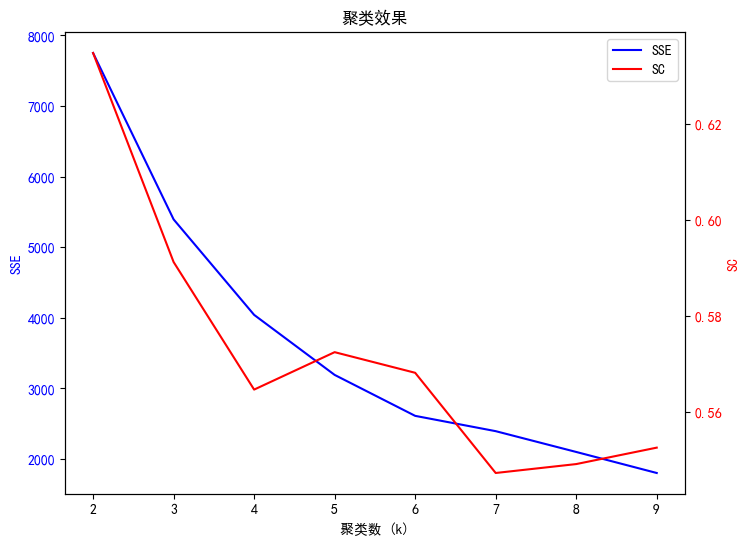

In [22]:
user_score =  joblib.load(f'用户聚类指标.score')
draw([str(x) for x in range(2,10)], user_score['sse'], user_score['sc'])

根据综合肘部法则和SC值，选择K=4作为用户的聚类模型

In [41]:
user_km=joblib.load(f'用户4聚类.model')
user_centers = pd.DataFrame(user_km.cluster_centers_, columns=user_df.columns) #提取聚类中心
user_centers['人数']=pd.Series(user_km.predict(user_data)).value_counts()
user_centers

,uid,浏览量,点赞量,观看作者数,观看作品数,观看作品平均时长,观看配乐数,完整观看数,去过的城市数,观看作品所在的城市数,人数
0,37136.592629,38.049229,0.389078,36.785240,38.049049,11.274518,33.284433,15.104286,1.184900,26.536496,11170
1,55079.529374,18.628347,0.168126,18.198833,18.628220,11.370955,17.325213,8.204416,1.144398,15.092120,7855
2,6652.697726,64.775251,0.574713,62.187087,64.774435,11.197168,54.662672,24.207141,1.242684,40.790658,12278
3,20457.454376,30.716015,0.334171,29.843482,30.715456,11.257726,27.695345,13.744507,1.218063,23.116201,10737


## 用户各类分析

### 聚类0：高浏览量、低互动性用户

浏览量较高，点赞量较低，观看作品数和作者数量较多，但观看作品的平均时长中等，且去过的城市数量较少，但是观看的作品所在城市较多

这个聚类的人数是较多的

**这个聚类用户的活跃度较高，但互动性较低**

**用户可能更喜欢浏览内容，但是不太愿意点赞和互动**

**用户的地理分布较广，但实际去过的城市较少**

### 建议

设计激励机制（如积分、奖励），提高用户的互动性；推荐更多相关内容，提升用户的浏览体验

推荐：高质量、短小精悍的视频，吸引用户的注意力，提供更多样化的内容（如热门视频，搞笑视频等）

设计互动激励机制，例如：点赞抽奖或者评论有礼

利用用户的浏览历史，推荐与其兴趣相关的内容，提升用户的停留时间

### 聚类1：低活跃度、低互动性用户

浏览量较低，点赞量也最低，观看作品数和作者数较少，观看作品平均时长较高，去过的城市数较少，观看作品所在的城市数也较少，用户的数量中等

**这个聚类的用户活跃度较低，互动性也较低**

**用户可能更喜欢长时间观看少量的内容，但是不太愿意互动和浏览**

**用户的地理分布和实际去过的地方都较少**

### 建议

分析用户流失原因，优化内容推荐策略；提供更吸引人的内容，提升用户的活跃度

推荐长视频或系列视频（如纪录片、电视剧、电影解说），满足用户的长时间观看需求。提供轻松、治愈类内容（如自然风光、宠物视频），吸引用户的兴趣

通过推送通知或邮件，提醒用户观看新内容。提供“限时免费”或“独家内容”等等，吸引用户重新活跃

通过问卷调查或兴趣标签，挖掘用户的潜在兴趣，提供更精准的推荐

### 聚类2：高活跃度、高互动性用户

该类用户的浏览量最高，点赞量较高，观看作品数和观看作者数也最多，但是观看作品平均时间中等，去过的城市较多，观看作品所在城市最多，用户的数量也是最多的

**这个聚类的用户活跃度最高，互动性也较高**

**用户喜欢浏览大量内容，并且愿意点赞和互动**

**用户的地理分布最广，实际去过的城市也较多**

### 建议

提供更多优质内容，鼓励用户互动（如点赞、评论），增加跨城市的内容推荐，满足用户的地理分布需求

推荐热门、趋势性内容（如挑战赛、热点事件），满足用户的探索需求。提供互动性强的内容（如直播、问答视频），增强用户的参与感

推荐用户好友喜欢的内容，增强社交互动，提供“好友在看”或“同城推荐”，增加用户的粘性。

设计高级奖励机制（如 VIP 会员、专属内容），激励用户持续活跃

根据用户的地理分布，推荐跨城市的内容（如旅游攻略、文化差异），满足用户的探索需求

### 聚类 3：中等活跃度、中等互动性用户

浏览量、点赞量、观看作品数、观看作者数中和观看作品平均时长都是中等水平，但是去过的城市数较多，观看作品所在的城市数中等，用户数量较多。

**这个聚类的用户活跃度和互动性都处于中等水平**

**且用户的行为比较均衡，既不是特别活跃，也不是特别消极**

**地理分布和实际去过的城市都处于中等水平**

### 建议

保持内容的多样性和质量，维持用户的活跃度，提供个性化推荐，增强用户粘性

推荐中等时长的视频（如科普、教程、综艺片段），满足用户的观看需求，提供多样化的内容，保持用户的新鲜感

根据用户的浏览历史，推荐与其兴趣相关的内容，提供“猜你喜欢”或“热门推荐”，提升用户的观看时长

设计简单的互动任务（如点赞、分享），逐步提高用户的互动性

推荐本地化的内容（如本地新闻、活动），增强用户的归属感

## 作者聚类

In [33]:
author_score = km(author_data, '作者')

聚2类计算完成	聚3类计算完成	聚4类计算完成	聚5类计算完成	聚6类计算完成	聚7类计算完成	聚8类计算完成	聚9类计算完成	指标储存完毕


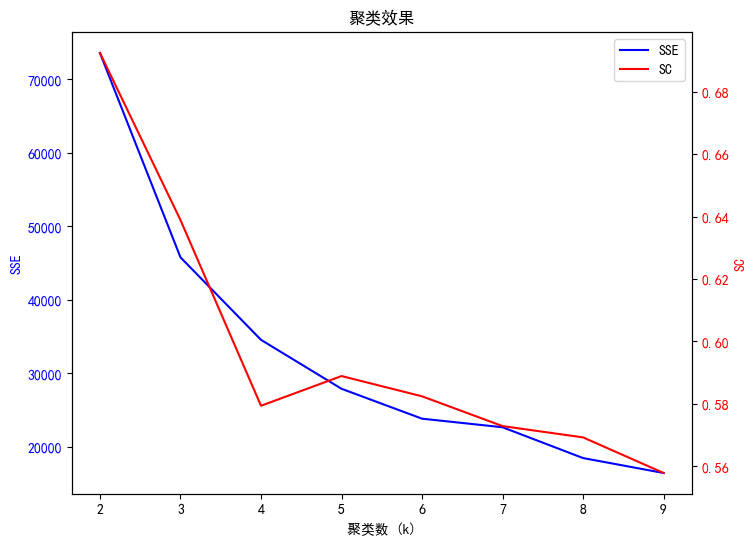

In [35]:
author_score =  joblib.load(f'作者聚类指标.score')
draw([str(x) for x in range(2,10)], author_score['sse'], author_score['sc'])

同样根据综合肘部法则和SC值，选择K=4作为用户的聚类模型

In [40]:
author_km = joblib.load(f'作者4聚类.model')
author_centers = pd.DataFrame(author_km.cluster_centers_, columns=author_df.columns)
author_centers['人数'] = pd.Series(author_km.predict(author_data)).value_counts()
author_centers

,author_id,总作品数,总浏览量,总点赞量,总观完量,使用的配乐数量,去过的城市数,发布作品的日期数,作品的平均时长,创造活跃度(日),人数
0,141948.657294,3.502643,11.921919,0.121943,5.106954,3.127985,1.109801,3.502527,10.883162,12.015337,17190
1,577267.809562,1.560373,8.020665,0.058549,3.788088,1.489668,1.049433,1.560170,10.793588,3.831442,4933
2,280990.889258,2.393415,10.147406,0.094945,4.589707,2.211506,1.091453,2.393415,10.688268,8.326987,12008
3,40672.333238,6.410529,41.791922,0.394750,17.797407,5.200776,1.160671,6.410137,10.952308,15.286009,28122


## 作者各类分析

### 聚类 0：新手作者

总浏览量较低，总点赞量最低，总作品数较少，且作品的平均时长也较短，使用的配乐数量同样也较少，发布作品日数也较少，创作的活跃度较低，去过的城市数量较少，这个类别的数量也是最多的

**该聚类的作者活跃度较低，作品数量和质量都较低**

**可能是新手作者或偶尔发布内容的用户**

**需要更多的创作支持和激励**

### 建议

提供创作教程和工具，帮助新手作者提升作品质量

设计新手任务和奖励机制，激励作者持续创作

提供新手作者的专属推荐位，增加作品的曝光量

也可以举办新手作者比赛，鼓励用户参与

### 聚类1：不活跃作者

作品最少，总浏览量最低，总点赞量最低，且使用的配乐数量同样也最少，发布作品日数也最少，创作的活跃度最低，去过的城市数量最少，这个类别的数量较多

**该聚类的作者活跃度最低，作品数量和质量都最差**

**可能是非常不活跃的用户，或者只是偶尔发布内容的用户**

**需要更多的唤醒策略和激励机制**

### 建议

通过推送通知或邮件，提醒作者发布新内容

提供“限时免费”或“独家内容”，吸引作者重新活跃

设计简单的任务和奖励机制（如发布作品奖励），激励作者参与创作

### 聚类2：潜力作者

总作品数、总浏览量、总点赞量、使用的配乐数、去过的城市数、发布作品的日期数、作品的平均时长、创作活跃度全部都是中等水平，单该段的作者数量较多

**这个聚类的作者活跃度和作品质量都处于中等水平**

**可能是潜力作者，有一定的创作能力但尚未完全发挥**

**需要更多的创作指导和资源支持**

### 建议

提供创作培训和指导，帮助作者提升作品质量

设计潜力作者的专属推荐位，增加作品的曝光量

设计潜力作者的奖励机制（如流量扶持、现金奖励），激励作者持续创作

### 聚类3：高级作者

总作品数最多，总浏览量最高，总点赞量最高，且使用的配乐数量和去过的城市数都是最多，发布作品的日期数最多，作品平均时长也较长，创作活跃度最高，作者数量最多